In [1]:
#%% Importação dos pacotes

import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
import lightgbm as lgbm
import matplotlib.pyplot as plt

In [2]:
#%% Carregar dados
titanic = pd.read_pickle('titanic1.pkl')
X = titanic.drop(columns='survived')
y=titanic.survived

In [3]:
#%% Dividir os dados em treino e teste (holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
#%% Definir o modelo LightGBM e os hiperparâmetros para otimização
# Criando um classificador base
lgbm_clf = lgbm.LGBMClassifier(boosting_type='gbdt', 
                               objective='binary', 
                               random_state=42)

In [5]:
# Definição do espaço de busca para otimização bayesiana
param_grid = {
    'num_leaves': (20, 60),  # Número de folhas na árvore de decisão
    'max_depth': (3, 15),  # Profundidade máxima da árvore
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Taxa de aprendizado
    'n_estimators': (50, 100),  # Número de árvores
    'subsample': (0.5, 1.0),  # Proporção de amostras usadas em cada árvore
    'colsample_bytree': (0.5, 1.0),  # Fração de colunas a serem usadas por árvore
    'reg_alpha': (1e-5, 1.0, 'log-uniform'),  # Regularização L1
    'reg_lambda': (1e-5, 1.0, 'log-uniform'),  # Regularização L2
}


In [6]:
#%% Configurar a busca Bayesiana usando BayesSearchCV

# Criando o otimizador Bayesiano
bayes_search = BayesSearchCV(
    estimator=lgbm_clf,  # Modelo a ser otimizado
    search_spaces=param_grid,  # Espaço de busca definido acima
    scoring='roc_auc',  # Critério de seleção: Área sob a curva ROC (AUC)
    n_iter=10,  # Número de avaliações do modelo
    cv=3,  # Validação cruzada com 5 folds
    random_state=42,
    n_jobs=-1,  # Paralelização total dos cálculos
    verbose=0
)

In [7]:
#%% Executar a busca Bayesiana

start_time = time.time()
bayes_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 159, number of negative: 256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 415, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383133 -> initscore=-0.476273
[LightGBM] [Info] Start training from score -0.476273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


BayesSearchCV(cv=3,
              estimator=LGBMClassifier(objective='binary', random_state=42),
              n_iter=10, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': (0.5, 1.0),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 15), 'n_estimators': (50, 100),
                             'num_leaves': (20, 60),
                             'reg_alpha': (1e-05, 1.0, 'log-uniform'),
                             'reg_lambda': (1e-05, 1.0, 'log-uniform'),
                             'subsample': (0.5, 1.0)})

In [8]:
# Parar o cronômetro
end_time = time.time()
elapsed_time = end_time - start_time

In [9]:
#%% Resultados da busca
auc = bayes_search.best_score_
gini = auc*2-1
print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")
print(f"\ngini média na validação cruzada: {gini:.2%}")
print(f"\nTempo total de execução: {elapsed_time:.2f} segundos")


Melhores hiperparâmetros: OrderedDict([('colsample_bytree', 0.5018151536273716), ('learning_rate', 0.16144853360713746), ('max_depth', 12), ('n_estimators', 63), ('num_leaves', 43), ('reg_alpha', 0.00023636014306385768), ('reg_lambda', 0.0003666034360775116), ('subsample', 0.5762972934192222)])

gini média na validação cruzada: 73.46%

Tempo total de execução: 9.89 segundos


In [10]:
#%% Treinar o modelo final com os melhores hiperparâmetros
final_clf = bayes_search.best_estimator_


In [11]:
# Avaliar no conjunto de teste
bayes_test_score = final_clf.score(X_test, y_test)
bayes_roc = roc_auc_score(y_test, final_clf.predict_proba(X_test)[:,1])
bayes_gini = bayes_roc*2-1
print(f"Acurácia do bayesian search no teste: {bayes_test_score:.4f}")
print(f"Gini do bayesian search no teste: {bayes_gini:.4f}")


Acurácia do bayesian search no teste: 0.8022
Gini do bayesian search no teste: 0.6510


In [12]:
#%% Avaliação do melhor modelo encontrado

# Melhor conjunto de hiperparâmetros
best_params = bayes_search.best_params_
print("Melhores parâmetros encontrados:", best_params)


Melhores parâmetros encontrados: OrderedDict([('colsample_bytree', 0.5018151536273716), ('learning_rate', 0.16144853360713746), ('max_depth', 12), ('n_estimators', 63), ('num_leaves', 43), ('reg_alpha', 0.00023636014306385768), ('reg_lambda', 0.0003666034360775116), ('subsample', 0.5762972934192222)])


AUC no conjunto de teste: 0.8255


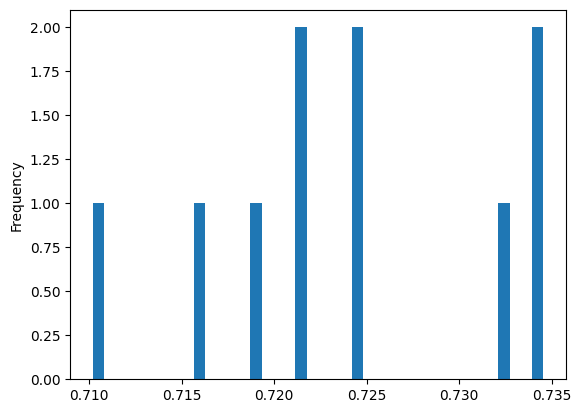

In [13]:
# Avaliação no conjunto de teste
best_model = bayes_search.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC no conjunto de teste: {auc_score:.4f}")

#%%
resultados_bayes = pd.DataFrame(bayes_search.cv_results_)
resultados_bayes['gini'] = resultados_bayes.mean_test_score*2-1
resultados_bayes.gini.plot.hist(bins=40)
plt.show()